# **Luke McMeans - Data Project 1**

In [199]:
# imports
import pandas as pd
import json
from dotenv import load_dotenv
import os
import sqlite3
import requests
import time
import seaborn as sns
import matplotlib.pyplot as plt

API Key (hidden in .env file but can be manually inputted by replacing `"!! SET DEFAULT HERE"`)

In [200]:
# get API key
load_dotenv()
api_key = os.getenv("API_KEY", "!! SET DEFAULT HERE")

# **Conversion Functions**

General function to convert a df to a desired file type

In [201]:
def convert_from_df(input_df: pd.DataFrame, result_type: str, name: str = "countries"):
    # convert based on result type
    output_type = result_type.lower()
    if output_type == "sql":
        conn = sqlite3.connect(f'output_data/{name}.db')
        input_df.to_sql('table', conn, if_exists='replace', index=False)
        conn.close()
    elif output_type == "csv":
        input_df.to_csv(f"output_data/{name}.csv", index=False, mode='w')
    elif output_type == "json":
        with open(f"output_data/{name}.json", 'w') as outfile:
            input_df.to_json(outfile, orient='records', indent=4)
    else:
        raise ValueError("Desired output isn't SQL, CSV, or JSON")

Handling conversions from SQL file

In [211]:
def convert_from_sql(db_file_path: str, result_type: str, name: str = "countries"):
    # connect to the database file
    conn = sqlite3.connect(db_file_path)
    cursor = conn.cursor()
    
    # get the first (should be only) table name
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    if not tables:
        raise ValueError("No tables found in the database file.")
    table_name = tables[0][0]
    
    # read the table into a df
    temp_df = pd.read_sql_query(f'SELECT * FROM "{table_name}"', conn)
    conn.close()
    
    # convert to desired format
    convert_from_df(temp_df, result_type, name)

Handling file conversions for JSON

In [203]:
def convert_from_json(json_file_path: str, result_type: str, name: str = "countries"):
    # read file
    try:
        # try to read as a regular json file
        with open(json_file_path, 'r') as file:
            json_data = json.load(file)
    except json.JSONDecodeError:
        # try reading line by line in case of error
        json_data = []
        with open(json_file_path, 'r') as file:
            for line in file:
                try:
                    if line.strip():
                        json_data.append(json.loads(line))
                except json.JSONDecodeError:
                    continue
    
    # create df and convert
    temp_df = pd.DataFrame(json_data)
    convert_from_df(temp_df, result_type, name)

Handling file conversions for CSV

In [204]:
# converting from csv directly
def convert_from_csv(csv_file_path: str, result_type: str, name: str = "countries"):
    # read file and convert
    temp_df = pd.read_csv(csv_file_path)
    convert_from_df(temp_df, result_type, name)

# **Retrieving Input Data (countries_data.csv)**

In [160]:
# load data
csv_df = pd.read_csv('input_data/countries_input.csv')

# show df
csv_df

,name,capital,population,area,region
0,South Georgia,King Edward Point,30,3903.0,Antarctic
1,Grenada,St. George's,112519,344.0,Americas
2,Switzerland,Bern,8654622,41284.0,Europe
3,Sierra Leone,Freetown,7976985,71740.0,Africa
4,Hungary,Budapest,9749763,93028.0,Europe
...,...,...,...,...,...
245,Belgium,Brussels,11555997,30528.0,Europe
246,Israel,Jerusalem,9216900,20770.0,Asia
247,New Zealand,Wellington,5084300,270467.0,Oceania
248,Nicaragua,Managua,6624554,130373.0,Americas


In [161]:
# printing shape
print(f"Number of records: {csv_df.shape[0]}")
print(f"Number of columns: {csv_df.shape[1]}")

# count of countries within each region
region_counts = csv_df['region'].value_counts()
print("\nCount of countries within each region:")
print(region_counts)

# statistical summary of numerical columns
print("\nStatistical summary for 'population' and 'area': ")
csv_df[['population', 'area']].describe().round(2)

Number of records: 250
Number of columns: 5

Count of countries within each region:
region
Africa       59
Americas     56
Europe       53
Asia         50
Oceania      27
Antarctic     5
Name: count, dtype: int64

Statistical summary for 'population' and 'area': 


,population,area
count,2.500000e+02,250.00
mean,3.111089e+07,600584.81
std,1.296673e+08,1909804.91
min,0.000000e+00,0.44
25%,2.210995e+05,1194.25
50%,4.912244e+06,64929.50
75%,1.902577e+07,372726.00
max,1.402112e+09,17098242.00


# **Retrieving API Data**

In [162]:
# list of each country
countries = csv_df['name'].values
countries

array(['South Georgia', 'Grenada', 'Switzerland', 'Sierra Leone',
       'Hungary', 'Taiwan', 'Wallis and Futuna', 'Barbados',
       'Pitcairn Islands', 'Ivory Coast', 'Tunisia', 'Italy', 'Benin',
       'Indonesia', 'Cape Verde', 'Saint Kitts and Nevis', 'Laos',
       'Caribbean Netherlands', 'Uganda', 'Andorra', 'Burundi',
       'South Africa', 'France', 'Libya', 'Mexico', 'Gabon',
       'Northern Mariana Islands', 'North Macedonia', 'China', 'Yemen',
       'Saint Barthélemy', 'Guernsey', 'Solomon Islands',
       'Svalbard and Jan Mayen', 'Faroe Islands', 'Uzbekistan', 'Egypt',
       'Senegal', 'Sri Lanka', 'Palestine', 'Bangladesh', 'Peru',
       'Singapore', 'Turkey', 'Afghanistan', 'Aruba', 'Cook Islands',
       'United Kingdom', 'Zambia', 'Finland', 'Niger', 'Christmas Island',
       'Tokelau', 'Guinea-Bissau', 'Azerbaijan', 'Réunion', 'Djibouti',
       'North Korea', 'Mauritius', 'Montserrat',
       'United States Virgin Islands', 'Colombia', 'Greece', 'Croatia',
   

In [163]:
# create a list to track all data, as well as those countries that couldn't be process
api_data = []
error_countries = []

In [164]:
# retrieve api data for each country
for country in countries:
    try:
        # make api call
        api_url = 'https://api.api-ninjas.com/v1/country?name={}'.format(country)
        response = requests.get(api_url, headers={'X-Api-Key': api_key})

        # add data when retrieved 
        if response.status_code == 200 and response.json():
            data = response.json()[0]
            data['name'] = country
            api_data.append(data)
        else:
            # couldn't get data for the country
            error_countries.append(country)
        time.sleep(0.1)
    except Exception as e:
        # error thrown when processing country
        error_countries.append(country)
        continue

In [165]:
# printing countires that couldn't get data
print("Couldn't retrieve data for the following countries:")
for country in sorted(error_countries):
    print(f"- {country}")

Couldn't retrieve data for the following countries:
- Antarctica
- Bouvet Island
- British Indian Ocean Territory
- Cape Verde
- Caribbean Netherlands
- Christmas Island
- Cocos (Keeling) Islands
- DR Congo
- French Southern and Antarctic Lands
- Guernsey
- Heard Island and McDonald Islands
- Ivory Coast
- Jersey
- Laos
- Macau
- Norfolk Island
- North Korea
- Pitcairn Islands
- Saint Barthélemy
- Saint Martin
- South Georgia
- South Korea
- Svalbard and Jan Mayen
- Taiwan
- United States Minor Outlying Islands
- United States Virgin Islands
- Åland Islands


In [166]:
# turn api data into a df
if api_data:
    api_df = pd.DataFrame(api_data)
else:
    raise ValueError("No data retrieved from API calls")

# take 'name' variable from currency dict
api_df['currency'] = api_df['currency'].apply(lambda x: x['name'] if isinstance(x, dict) else x)

# bring name to the first column
api_df = api_df[['name'] + [col for col in api_df.columns if col != 'name']]
api_df

,name,gdp,sex_ratio,surface_area,life_expectancy_male,imports,homicide_rate,currency,iso2,urban_population_growth,...,internet_users,gdp_per_capita,fertility,refugees,primary_school_enrollment_male,unemployment,employment_services,employment_industry,employment_agriculture,co2_emissions
0,Grenada,1169.0,101.5,345.0,70.1,470.0,10.8,E. Caribbean Dollar,GD,0.5,...,59.1,10485.9,2.1,0.0,107.7,NaN,NaN,NaN,NaN,NaN
1,Switzerland,705141.0,98.5,41291.0,81.6,276292.0,0.6,Swiss Franc,CH,1.2,...,89.7,82708.5,1.5,120.1,105.5,4.8,77.2,20.0,2.9,37.1
2,Sierra Leone,4101.0,99.6,72300.0,53.2,741.0,1.7,Leone,SL,3.3,...,9.0,536.1,4.3,0.4,110.8,4.4,39.1,6.5,54.4,NaN
3,Hungary,157883.0,90.8,93024.0,73.0,116556.0,2.5,Forint,HU,0.2,...,76.1,16264.0,1.5,6.4,101.1,3.5,62.6,32.8,4.6,45.8
4,Wallis and Futuna,NaN,93.4,142.0,72.8,65.0,NaN,Cfp Franc,WF,0.0,...,9.0,NaN,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,Belgium,543026.0,98.3,30528.0,79.0,426489.0,1.7,Euro,BE,0.7,...,88.7,47293.0,1.7,83.5,103.9,5.7,78.4,20.6,0.9,90.4
219,Israel,370588.0,99.1,22072.0,81.0,76579.0,1.5,New Israeli Sheqel,IL,1.7,...,83.7,44214.9,3.0,55.1,104.4,3.8,82.3,16.8,0.9,63.8
220,New Zealand,207921.0,96.7,268107.0,80.3,42271.0,0.7,New Zealand Dollar,NZ,1.1,...,90.8,43836.2,1.9,2.6,99.8,4.0,75.1,19.4,5.6,32.2
221,Nicaragua,13118.0,97.2,130373.0,70.6,8426.0,7.2,Cordoba Oro,NI,1.5,...,27.9,2028.9,2.4,0.8,121.1,7.4,53.8,15.6,30.6,5.1


In [167]:
# printing shape
print(f"Number of records: {api_df.shape[0]}")
print(f"Number of columns: {api_df.shape[1]}")

# count of countries within each region
region_counts = api_df['region'].value_counts()
print("\nCount of countries within each region:")
print(region_counts)

# statistical summary of some numerical columns
print("\nStatistical summary for specific columns: ")
api_df[['gdp', 'gdp_per_capita', 'urban_population_growth', 'life_expectancy_male', 'life_expectancy_female', 'internet_users', 'imports']].describe().round(2)

Number of records: 223
Number of columns: 38

Count of countries within each region:
region
Caribbean             21
Eastern Africa        19
Western Asia          18
Southern Europe       17
Western Africa        15
South America         14
Western Europe        13
Northern Europe       12
Eastern Europe        10
South-Eastern Asia    10
Polynesia              9
Southern Asia          9
Middle Africa          8
Central America        8
Micronesia             7
Northern Africa        7
Melanesia              5
Central Asia           5
Southern Africa        5
Northern America       5
Eastern Asia           4
Oceania                2
Name: count, dtype: int64

Statistical summary for specific columns: 


,gdp,gdp_per_capita,urban_population_growth,life_expectancy_male,life_expectancy_female,internet_users,imports
count,206.00,206.00,223.00,209.00,209.00,210.00,209.00
mean,441817.87,18298.45,1.86,70.46,75.38,57.59,98406.64
std,1817674.72,26982.59,1.76,7.33,7.77,28.53,277064.04
min,46.00,99.60,-3.60,50.40,54.80,1.30,1.00
25%,6810.75,2276.22,0.50,66.00,71.30,33.65,1711.00
50%,30422.50,7086.70,1.70,71.30,77.50,64.15,8370.00
75%,235223.25,23160.92,3.05,76.20,80.80,80.85,52696.00
max,20580223.00,185835.00,8.00,81.80,87.50,99.70,2567490.00


# **Manipulating and Merging Data**

I've noticed that North Korea, South Korea, and Laos were unable to be called in the API. After research, they go under their formal names here. Let's apply that and adjust.

In [174]:
# south korea api call
sk_url = 'https://api.api-ninjas.com/v1/country?name={}'.format('Republic of Korea')
sk_response = requests.get(sk_url, headers={'X-Api-Key': api_key})
sk_data = sk_response.json()[0]
sk_data['name'] = 'South Korea'
sk_data['currency'] = sk_data['currency']['name']

# north korea api call
nk_url = 'https://api.api-ninjas.com/v1/country?name={}'.format('Democratic People\'s Republic of Korea')
nk_response = requests.get(nk_url, headers={'X-Api-Key': api_key})
nk_data = nk_response.json()[0]
nk_data['name'] = 'North Korea'
nk_data['currency'] = nk_data['currency']['name']

# laos api call
laos_url = 'https://api.api-ninjas.com/v1/country?name={}'.format('Lao People\'s Democratic Republic')
laos_response = requests.get(laos_url, headers={'X-Api-Key': api_key})
laos_data = laos_response.json()[0]
laos_data['name'] = 'Laos'
laos_data['currency'] = laos_data['currency']['name']

# adding data to the api_df
api_df = pd.concat([api_df, pd.DataFrame([sk_data, nk_data, laos_data])], ignore_index=True)

# remove from error countries
error_countries = [country for country in error_countries if country not in ['North Korea', 'South Korea', 'Laos']]

In [176]:
# print all columns from api dataframe
print(api_df.columns)

Index(['name', 'gdp', 'sex_ratio', 'surface_area', 'life_expectancy_male',
       'imports', 'homicide_rate', 'currency', 'iso2',
       'urban_population_growth', 'secondary_school_enrollment_female',
       'capital', 'forested_area', 'tourists', 'exports',
       'life_expectancy_female', 'post_secondary_enrollment_female',
       'post_secondary_enrollment_male', 'primary_school_enrollment_female',
       'infant_mortality', 'gdp_growth', 'threatened_species', 'population',
       'urban_population', 'secondary_school_enrollment_male', 'pop_growth',
       'region', 'pop_density', 'internet_users', 'gdp_per_capita',
       'fertility', 'refugees', 'primary_school_enrollment_male',
       'unemployment', 'employment_services', 'employment_industry',
       'employment_agriculture', 'co2_emissions', 'average_life_expectancy'],
      dtype='object')


Let's also make a average life expectancy columns for later usage

In [177]:
# calculate average life expectancy using sex ratio and life expectancy of males/females
api_df['average_life_expectancy'] = api_df.apply(lambda row: 
    round(((row['life_expectancy_male'] * row['sex_ratio'] + row['life_expectancy_female'] * 100) / (row['sex_ratio'] + 100)), 1)
    if pd.notnull(row['life_expectancy_male']) and pd.notnull(row['life_expectancy_female']) and pd.notnull(row['sex_ratio'])
    else None, axis=1)

# display new data
display(api_df[['name', 'sex_ratio', 'life_expectancy_male', 'life_expectancy_female', 'average_life_expectancy']])

,name,sex_ratio,life_expectancy_male,life_expectancy_female,average_life_expectancy
0,Grenada,101.5,70.1,75.0,72.5
1,Switzerland,98.5,81.6,85.4,83.5
2,Sierra Leone,99.6,53.2,54.8,54.0
3,Hungary,90.8,73.0,80.1,76.7
4,Wallis and Futuna,93.4,72.8,78.7,75.9
...,...,...,...,...,...
221,Nicaragua,97.2,70.6,77.7,74.2
222,Anguilla,97.6,NaN,NaN,NaN
223,South Korea,95.7,68.3,75.4,71.9
224,North Korea,95.7,68.3,75.4,71.9


**Combining DataFrames**

Given the API is 'live' as opposed to a preloaded csv file, we will use the API's population data. It also can tie into other population-related statistics, so that's a plus. However, I will be using the CSV's region column as it provides a smaller, cleaner set of categorical variables to analyze if needed. Area will also be used from the CSV.

Here's the columns we'll pull from the two DFs:
- Name
- Capital 
- Region
- Area
- Population
- Population Density
- Urban Population
- Population Growth
- Urban Population Growth
- GDP
- GDP Per Capita
- GDP Growth
- Life Expectancy (Average, Male, and Female)
- Unemployment
- Internet Users

In [178]:
# merge the two dataframes together, only include countries in both dfs
df_1 = csv_df[~csv_df['name'].isin(error_countries)][['name', 'capital', 'region','area']].sort_values(by='name')
df_2 = api_df[['name', 'population', 'pop_density', 'urban_population', 'pop_growth',
               'urban_population_growth', 'gdp', 'gdp_per_capita', 'gdp_growth', 
               'average_life_expectancy', 'life_expectancy_male', 'life_expectancy_female',
               'unemployment', 'internet_users']].sort_values(by='name')
df = pd.merge(df_1, df_2, on='name')

df

,name,capital,region,area,population,pop_density,urban_population,pop_growth,urban_population_growth,gdp,gdp_per_capita,gdp_growth,average_life_expectancy,life_expectancy_male,life_expectancy_female,unemployment,internet_users
0,Afghanistan,Kabul,Asia,652230.0,38928.0,59.6,25.8,2.5,4.0,20514.0,551.9,-1.7,64.3,62.8,65.8,11.2,13.5
1,Albania,Tirana,Europe,28748.0,2878.0,105.0,61.2,-0.1,1.8,15059.0,5223.8,4.1,78.4,76.7,80.1,12.8,71.8
2,Algeria,Algiers,Africa,2381741.0,43851.0,18.4,73.2,2.0,2.9,173757.0,4114.7,1.4,76.6,75.4,77.8,11.5,49.0
3,American Samoa,Pago Pago,Oceania,199.0,56.0,279.0,87.1,0.1,-0.1,NaN,NaN,NaN,74.4,71.1,77.8,9.2,NaN
4,Andorra,Andorra la Vella,Europe,468.0,77.0,164.2,88.0,-0.2,-1.7,3238.0,42051.6,1.6,NaN,NaN,NaN,NaN,91.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,Wallis and Futuna,Mata-Utu,Oceania,142.0,12.0,82.5,0.0,-0.9,0.0,NaN,NaN,NaN,75.9,72.8,78.7,NaN,9.0
222,Western Sahara,El Aaiún,Africa,266000.0,597.0,2.2,86.8,2.5,1.9,NaN,NaN,NaN,70.0,68.2,71.9,9.4,NaN
223,Yemen,Sana'a,Asia,527968.0,29826.0,56.5,37.3,2.4,4.4,26672.0,935.9,-1.3,66.0,64.4,67.7,12.8,26.7
224,Zambia,Lusaka,Africa,752612.0,18384.0,24.7,44.1,2.9,4.3,27283.0,1572.3,4.1,63.3,60.3,66.2,11.4,14.3


# **Analysis**

**Largest and smallest population growth**

In [179]:
# define the amount of instances we want to retrieve
length = 10

# finding countries with highest growth (tiebreaker is population)
top_pop_growth = df.nlargest(length, ['pop_growth', 'population'])

# print results
print("Countries with the highest population growth:")
for i, row in enumerate(top_pop_growth.iterrows(), start=1):
    print(f"{i}. {row[1]['name']} ({row[1]['pop_growth']})")

# finding countries with lowest growth (tiebreaker is population)
bottom_pop_growth = df.nsmallest(length, ['pop_growth', 'population'])

# print results
print("\nCountries with the lowest population growth:")
for i, row in enumerate(bottom_pop_growth.iterrows(), start=1):
    print(f"{i}. {row[1]['name']} ({row[1]['pop_growth']})")

Countries with the highest population growth:
1. Bahrain (4.3)
2. Equatorial Guinea (3.7)
3. Uganda (3.6)
4. Oman (3.6)
5. Maldives (3.4)
6. Angola (3.3)
7. Burundi (3.1)
8. Tanzania (3.0)
9. Mali (3.0)
10. Chad (3.0)

Countries with the lowest population growth:
1. Puerto Rico (-3.3)
2. Lithuania (-1.5)
3. Latvia (-1.1)
4. Venezuela (-1.1)
5. Wallis and Futuna (-0.9)
6. Bosnia and Herzegovina (-0.9)
7. Bulgaria (-0.7)
8. Romania (-0.7)
9. Croatia (-0.6)
10. Syria (-0.6)


**Correlation between population growth variables**

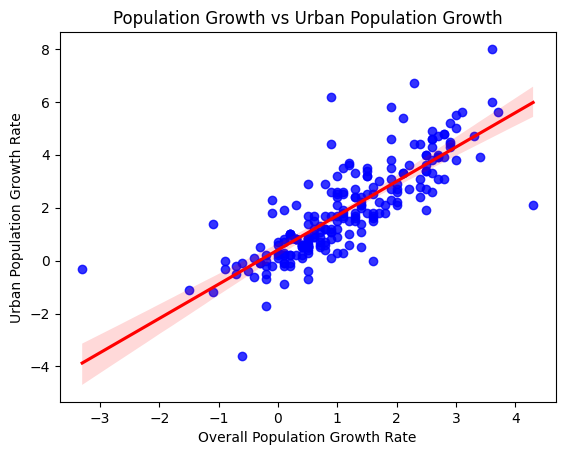

Correlation: 0.8171476685269314


In [180]:
# plot pop growth and urban population growth
sns.regplot(data=df, x='pop_growth', y='urban_population_growth', scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('Population Growth vs Urban Population Growth')
plt.xlabel('Overall Population Growth Rate')
plt.ylabel('Urban Population Growth Rate')
plt.show()

# calculate and print correlation
correlation = df['pop_growth'].corr(df['urban_population_growth'])
print(f"Correlation: {correlation}")

There is a general positive correlation between both types of population growth, but it's not 1-to-1. This correlation shows that urban population growth of a country commonly increases/decreases at a faster rate than their overall growth.

Similar process between population density and population growth rate

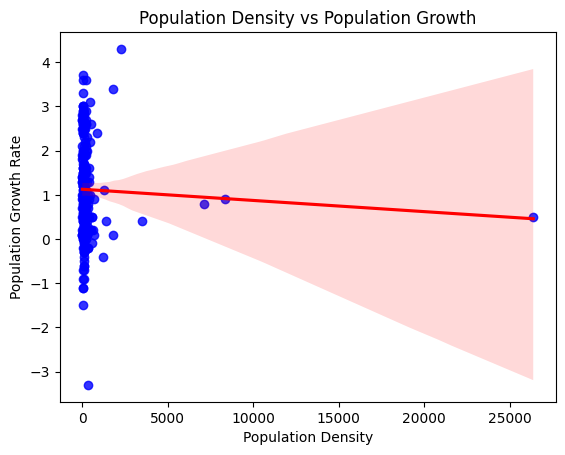

Correlation: -0.043678062408873765


In [181]:
# plot population density and pop growth
sns.regplot(data=df, x='pop_density', y='pop_growth', scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('Population Density vs Population Growth')
plt.xlabel('Population Density')
plt.ylabel('Population Growth Rate')
plt.show()

# calculate and print correlation
correlation = df['pop_density'].corr(df['pop_growth'])
print(f"Correlation: {correlation}")

There are a lot of outliers here... let's remove those to get a better view.

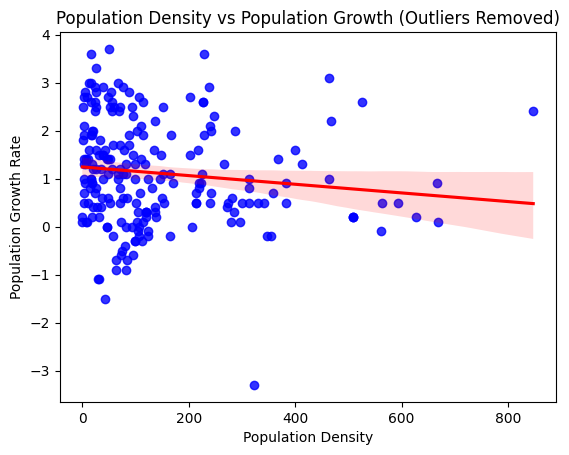

Correlation (Outliers Removed): -0.12553600551155514


In [182]:
# remove outliers from the dataset
df_filtered = df[(df['pop_density'] < 1000) & (df['pop_growth'] < 10)]

# plot population density and pop growth without outliers
sns.regplot(data=df_filtered, x='pop_density', y='pop_growth', scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('Population Density vs Population Growth (Outliers Removed)')
plt.xlabel('Population Density')
plt.ylabel('Population Growth Rate')
plt.show()

# calculate and print correlation without outliers
correlation = df_filtered['pop_density'].corr(df_filtered['pop_growth'])
print(f"Correlation (Outliers Removed): {correlation}")

It looks like we're still getting a similar correlation. It's not the same, but it still shows that there is no correlation between the two. Some countries have a low density with a high growth rate, and vice versa. Some countries have an above density with a hihg growth rate, and vice versa.

**Life Expectancy related Statistics**

Male:

In [183]:
# entries with the highest and lowest male life expectancy values
top_male_life_expectancy = df.nlargest(length, 'life_expectancy_male')
bottom_male_life_expectancy = df.nsmallest(length, 'life_expectancy_male')

# print findings
print("Countries with the highest male life expectancy:")
for i, row in enumerate(top_male_life_expectancy.iterrows(), start=1):
    print(f"{i}. {row[1]['name']} ({row[1]['life_expectancy_male']})")
print("\nCountries with the lowest male life expectancy:")
for i, row in enumerate(bottom_male_life_expectancy.iterrows(), start=1):
    print(f"{i}. {row[1]['name']} ({row[1]['life_expectancy_male']})")

Countries with the highest male life expectancy:
1. Hong Kong (81.8)
2. San Marino (81.7)
3. Switzerland (81.6)
4. Japan (81.3)
5. Australia (81.2)
6. Iceland (81.2)
7. Singapore (81.2)
8. Israel (81.0)
9. Italy (81.0)
10. Sweden (80.8)

Countries with the lowest male life expectancy:
1. Lesotho (50.4)
2. Central African Republic (50.5)
3. Chad (52.4)
4. Sierra Leone (53.2)
5. Niger (53.3)
6. Nigeria (53.3)
7. Eswatini (55.2)
8. Somalia (55.3)
9. Guinea-Bissau (55.8)
10. South Sudan (56.0)


Female:

In [184]:
# entries with the highest and lowest female life expectancy values
top_female_life_expectancy = df.nlargest(length, 'life_expectancy_female')
bottom_female_life_expectancy = df.nsmallest(length, 'life_expectancy_female')

# print findings
print("Countries with the highest female life expectancy:")
for i, row in enumerate(top_female_life_expectancy.iterrows(), start=1):
    print(f"{i}. {row[1]['name']} ({row[1]['life_expectancy_female']})")
print("\nCountries with the lowest female life expectancy:")
for i, row in enumerate(bottom_female_life_expectancy.iterrows(), start=1):
    print(f"{i}. {row[1]['name']} ({row[1]['life_expectancy_female']})")

Countries with the highest female life expectancy:
1. Hong Kong (87.5)
2. Japan (87.5)
3. San Marino (86.4)
4. Spain (86.0)
5. Singapore (85.5)
6. France (85.4)
7. Guadeloupe (85.4)
8. Italy (85.4)
9. Martinique (85.4)
10. Mayotte (85.4)

Countries with the lowest female life expectancy:
1. Sierra Leone (54.8)
2. Central African Republic (54.9)
3. Niger (55.1)
4. Nigeria (55.1)
5. Chad (55.2)
6. Lesotho (56.8)
7. Somalia (58.7)
8. South Sudan (58.9)
9. Equatorial Guinea (59.4)
10. Mali (59.5)


Overall:

In [185]:
# entries with the highest and lowest average life expectancy values
top_average_life_expectancy = df.nlargest(length, 'average_life_expectancy')
bottom_average_life_expectancy = df.nsmallest(length, 'average_life_expectancy')

# print findings
print("Countries with the highest average life expectancy:")
for i, row in enumerate(top_average_life_expectancy.iterrows(), start=1):
    print(f"{i}. {row[1]['name']} ({row[1]['average_life_expectancy']})")
print("\nCountries with the lowest average life expectancy:")
for i, row in enumerate(bottom_average_life_expectancy.iterrows(), start=1):
    print(f"{i}. {row[1]['name']} ({row[1]['average_life_expectancy']})")

Countries with the highest average life expectancy:
1. Hong Kong (84.9)
2. Japan (84.5)
3. San Marino (84.1)
4. Switzerland (83.5)
5. Italy (83.3)
6. Spain (83.3)
7. Australia (83.2)
8. Singapore (83.2)
9. Iceland (82.7)
10. Israel (82.7)

Countries with the lowest average life expectancy:
1. Central African Republic (52.7)
2. Lesotho (53.6)
3. Chad (53.8)
4. Sierra Leone (54.0)
5. Niger (54.2)
6. Nigeria (54.2)
7. Somalia (57.0)
8. South Sudan (57.4)
9. Guinea-Bissau (57.8)
10. Equatorial Guinea (58.2)


Regions ranked by average life expectancy

In [186]:
# average life expectancy, grouped by region
average_life_expectancy_by_region = df.groupby('region')['average_life_expectancy'].mean().round(1)

# print results
print("Regions ranked by average life expectancy:")
for i, (region, avg_life_expectancy) in enumerate(sorted(average_life_expectancy_by_region.items(), key=lambda x: x[1], reverse=True), start=1):
    print(f"{i}. {region} ({avg_life_expectancy})")

Regions ranked by average life expectancy:
1. Europe (79.3)
2. Americas (76.2)
3. Asia (73.8)
4. Oceania (73.0)
5. Africa (64.3)


In [187]:
# statistical summaries for average life expectancy, grouped by region
average_life_expectancy_summaries = df.groupby('region')['average_life_expectancy'].describe().round(1)

# print summaries
print("Statistical summaries for average life expectancy, grouped by region:")
display(average_life_expectancy_summaries)

Statistical summaries for average life expectancy, grouped by region:


,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Africa,54.0,64.3,6.9,52.7,60.2,63.6,67.2,82.5
Americas,45.0,76.2,3.9,63.6,73.9,76.1,79.0,82.5
Asia,48.0,73.8,4.7,64.3,70.7,73.4,76.8,84.9
Europe,43.0,79.3,3.4,71.8,76.4,80.7,82.0,84.1
Oceania,22.0,72.9,5.5,61.3,69.8,72.9,76.2,83.2


Our regions findings are in line with the individual stat icons. The overwhelming of the bottom life expectancy ratings were from countries within Africa. For the top, there was a mix between European and Asian nations.

**GDP per Capita and Internet Usage correlation**

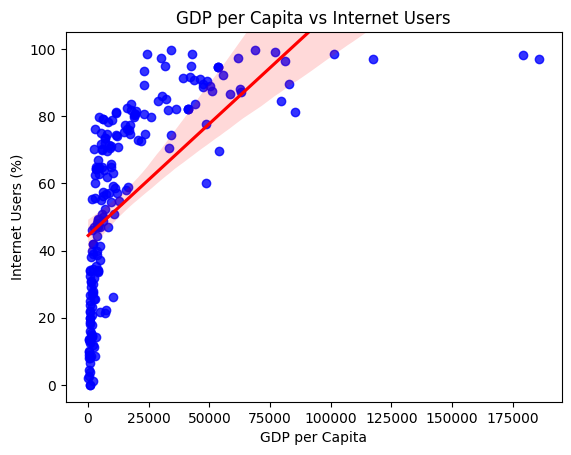

Correlation: 0.6278182342296648


In [188]:
# plot gdp per capita and internet usage
sns.regplot(data=df, x='gdp_per_capita', y='internet_users', scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('GDP per Capita vs Internet Users')
plt.xlabel('GDP per Capita')
plt.ylabel('Internet Users (%)')
plt.ylim(-5, 105)
plt.show()

# calculate and print correlation
correlation = df['gdp_per_capita'].corr(df['internet_users'])
print(f"Correlation: {correlation}")

This plot shows that there is a relative correlation between the two variables. Countries with a higher GDP per capita tend to have a larger portion of the population with internet access, and vice versa. The correlation seems to be more logarithmic in shape, with a sharp increase from a GDP/capita from 0 to 25000 and flatting from there.

**Overall GDP and Unemployment Correlation**

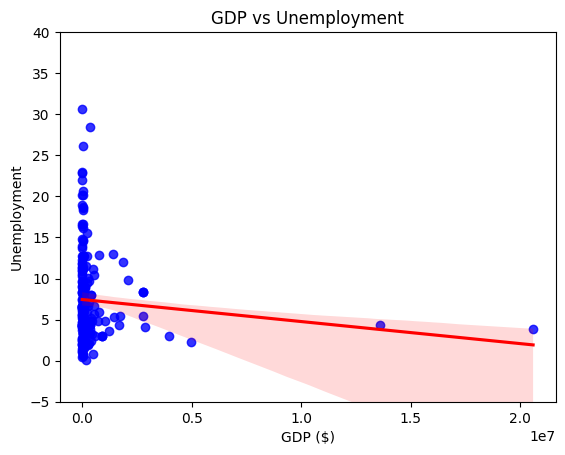

Correlation: -0.08993043491360249


In [189]:
# plot gdp and unemployment
sns.regplot(data=df, x='gdp', y='unemployment', scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('GDP vs Unemployment')
plt.xlabel('GDP ($)')
plt.ylabel('Unemployment')
plt.ylim(-5, 40)
plt.show()

# calculate and print correlation
correlation = df['gdp'].corr(df['unemployment'])
print(f"Correlation: {correlation}")

Seems like more outliers here... let's remove those and try again.

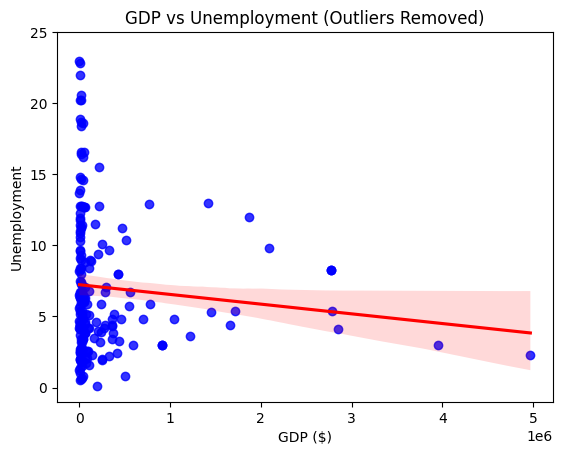

Correlation: -0.09610883673411355


In [190]:
# temp df with outliers removed
df_filtered = df[(df['gdp'] < df['gdp'].mean() + 3*df['gdp'].std()) & (df['unemployment'] < df['unemployment'].mean() + 3*df['unemployment'].std())]

# plot gdp and unemployment
sns.regplot(data=df_filtered, x='gdp', y='unemployment', scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('GDP vs Unemployment (Outliers Removed)')
plt.xlabel('GDP ($)')
plt.ylabel('Unemployment')
plt.ylim(-1, 25)
plt.show()

# calculate and print correlation
correlation = df_filtered['gdp'].corr(df_filtered['unemployment'])
print(f"Correlation: {correlation}")

Regardless of whether we remove outliers or not, there seems to be no real correlation between a countries GDP and their enemployment rate. Though the highest unemployment percentages are those with lower GDPs, the regression line can't give us enough information to say there is a trend.

# **Submission**

The completed file can be found in `output_data/countries.db`. A duplicate will be put in the base directory for easier access.

In [209]:
# call upon file saving to submit
convert_from_df(df, 'SQL')

Converting the `.db` file to JSON and CSV 

In [212]:
# set file path
file_path = "output_data/countries.db"

# convert
convert_from_sql(file_path, 'JSON')
convert_from_sql(file_path, 'CSV')

The space below is for users to call upon the other conversion functions as desired: